# Mandatory Assignment 1

#### Part II: Convolutional Neural Networks

***

Please see the description of the assignment in the README file (section 2.2)

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

import random
import numpy as np
import os
from pathlib import Path

In [ ]:
# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

The following are local files imported into this notebook. This is one of the advantages of not using an online notebook like Google Colab or stand-alone notebooks like Jupyter: We can import local files and use them in our code, thus making it easier to manage our code and create a more modular structure.

In `/src`, we have the following files:
- `utils.py`: Contains utility functions (e.g., setting our device to GPU if available)
- `data.py`: Contains functions to load data, train/validation split, and data augmentation
- `training.py`: Contains a single but very important function: Our training loop.
- `evaluation.py`: Contains functions to evaluate our model and produce a classification report
- `visualization.py`: Contains functions to visualize our data and model performance

You are encouraged to look at these files to understand how they work. Particularly, the training and evaluation files are important to understand how we train our model and evaluate its performance.

In [2]:
# local files
from src.utils import get_device
from src.data import load_torch_data, to_dataloader, train_val_split
from src.training import fit
from src.evaluation import evaluate
from src.visualize import plot_training_history, plot_probabilities, show_cifar_img

### Activate GPU
If available. Note that this is not necessary, but it will speed up your training.

In [3]:
device = get_device()  # will default to 'cpu' if gpu is not available.

Running pytorch version (2.5.1) with backend = mps


### Load data

In [4]:
batch_size = 64  # number of samples per batch

torch.manual_seed(42)  # Set a random seed to ensure reproducibility

In [5]:
# Use transforms.compose method to reformat images for modeling,
# and save to variable preprocessing_stepss for later use.
# Think of this like sci-kit learn's pipeline method.
preprocessing_steps = transforms.Compose(
    [
        transforms.Resize((32,32)),             # Cifar-10 images are 32x32
        transforms.RandomCrop(32, padding=4),   # Data augmentation step: Randomly crop the image to 32x32
        transforms.RandomHorizontalFlip(),      # Data augmentation step: Randomly flip image horizontally
        transforms.ToTensor(),                  # Convert the image to a pytorch tensor
        transforms.Normalize(                   # Normalize the image (i.e. scale the image to have a mean of 0 and a standard deviation of 1)
            mean=[0.4914, 0.4822, 0.4465],      # FYI: The mean of the training dataset for your convenience
            std=[0.2023, 0.1994, 0.2010]        # FYI the standard deviation of the training dataset
        )
    ]
)

# load the training/validation data
train_val = load_torch_data(
    dataset="CIFAR10",
    root = 'data',                     # The root directory where the dataset will be stored
    download = True,                   # If the dataset is not found at root, it will be downloaded
    train = True,                      # The train dataset (as opposed to the test dataset)
    transform = preprocessing_steps  # transformations to be applied to the dataset (see steps above)
)

# load the testing data
test = load_torch_data(
    dataset = "CIFAR10",
    root = 'data',
    download = True,
    train = False,
    transform = preprocessing_steps
)

f"{len(train_val)=}, {len(test)=}"


Files already downloaded and verified
Files already downloaded and verified


'len(train_val)=50000, len(test)=10000'

In [6]:
# split training data in training and validation (just like train_test_split in sklearn)
train, val = train_val_split(train_val, val_ratio=0.2, seed=42)

f"{len(val)=}, {len(train)=}"

'len(val)=10000, len(train)=40000'

In [7]:
# create dataloders for easy batch loading during training
train_loader = to_dataloader(train, batch_size = batch_size, shuffle = True)
val_loader = to_dataloader(val, batch_size = batch_size, shuffle = False)
test_loader = to_dataloader(test, batch_size = batch_size, shuffle = False)

### Inspect data

In [8]:
train_val, test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
            ))

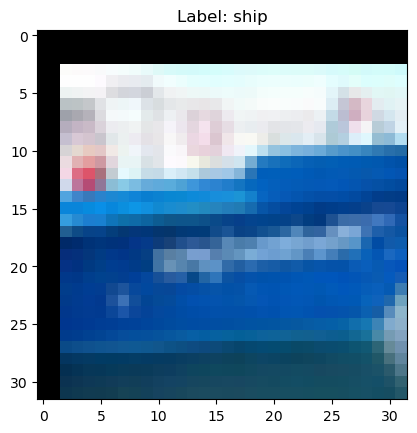

In [9]:
# Pick a random example from the training set
classes = train.dataset.classes
selection = random.randrange(len(train)-1)
image, label = train[selection]

show_cifar_img(image, label, classes)

***

### Convolutional neural network

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.batch_norm6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Block
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        # Activation function (shared)
        self.relu = nn.ReLU()

        # Dropout
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Convolutional Block 1
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Convolutional Block 2
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Convolutional Block 3
        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.batch_norm6(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Fully Connected Block
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x


### Training hyperparameters

In [11]:
# Define relevant variables for the ML task
LEARNING_RATE = 1e-3 #0.01 #TODO: Leave for exercise
WEIGHT_DECAY = 1e-4 #0.0001 #TODO: Leave for exercise
NUM_EPOCHS = 20 # TODO: leavve for exercise

In [12]:
model = CNN().to(device) # FYI; Sends the model to the GPU if set earlier

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

### Training

In [13]:
model, history = fit(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = NUM_EPOCHS,
    device = device,
    flatten = False  # don't flatten input tensors to 1D before passing to model. Convolutonal layers expect nD.
)

Epoch [1/20]: Train Loss: 1.6846 | Train Accuracy: 36.33% | Val Loss: 1.4119 | Val Accuracy: 49.18%
Epoch [2/20]: Train Loss: 1.2638 | Train Accuracy: 54.54% | Val Loss: 1.4393 | Val Accuracy: 51.13%
Epoch [3/20]: Train Loss: 1.0779 | Train Accuracy: 62.01% | Val Loss: 0.9651 | Val Accuracy: 66.14%
Epoch [4/20]: Train Loss: 0.9546 | Train Accuracy: 66.80% | Val Loss: 1.0133 | Val Accuracy: 64.37%
Epoch [5/20]: Train Loss: 0.8484 | Train Accuracy: 70.93% | Val Loss: 0.9130 | Val Accuracy: 68.05%
Epoch [6/20]: Train Loss: 0.7710 | Train Accuracy: 73.72% | Val Loss: 0.8111 | Val Accuracy: 72.75%
Epoch [7/20]: Train Loss: 0.7028 | Train Accuracy: 76.34% | Val Loss: 0.7724 | Val Accuracy: 74.12%
Epoch [8/20]: Train Loss: 0.6508 | Train Accuracy: 78.17% | Val Loss: 0.6486 | Val Accuracy: 78.08%
Epoch [9/20]: Train Loss: 0.5988 | Train Accuracy: 80.03% | Val Loss: 0.6292 | Val Accuracy: 78.36%
Epoch [10/20]: Train Loss: 0.5669 | Train Accuracy: 81.15% | Val Loss: 0.5803 | Val Accuracy: 79.92%

### Plot loss and accuracy

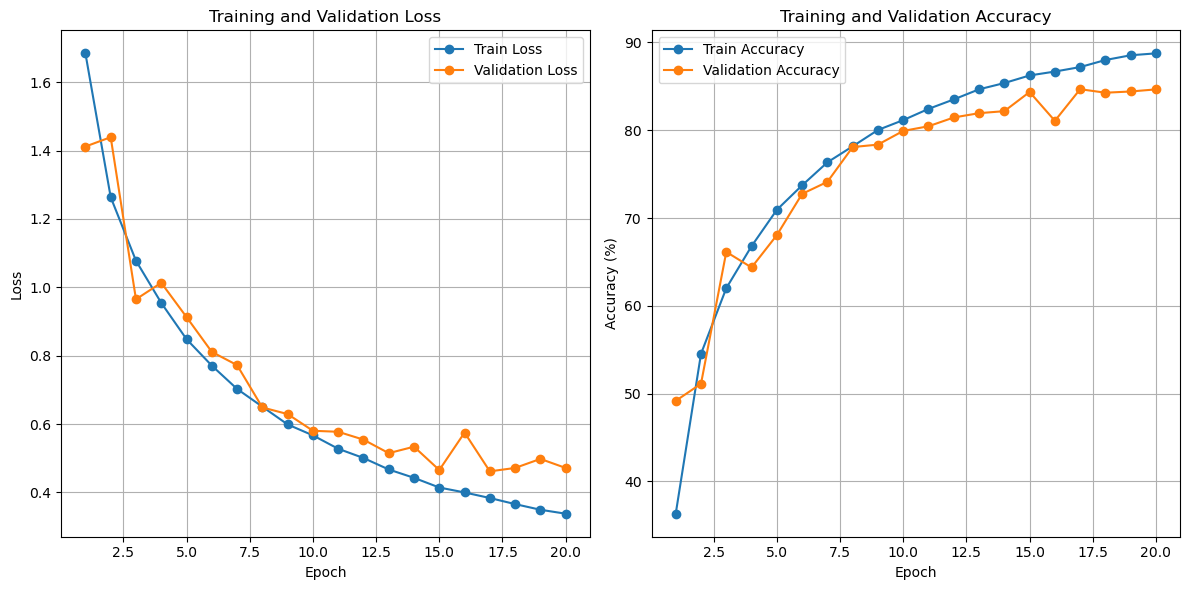

In [14]:
plot_training_history(history)

### Evaluate on training data

In [15]:
evaluate(
    model = model,
    data_loader = train_loader,  # evaluate on training data
    device = device,
    criterion = criterion,
    flatten = False  # don't flatten input tensors to 1D. Convolutonal layers expect nD.
)

Evaluation Results:
Loss: 0.3285, Accuracy: 88.79%

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4027
           1       0.99      0.82      0.90      3990
           2       0.94      0.80      0.86      3994
           3       0.83      0.82      0.82      4033
           4       0.87      0.91      0.89      4037
           5       0.93      0.79      0.85      3976
           6       0.93      0.93      0.93      3975
           7       0.87      0.96      0.91      3965
           8       0.88      0.98      0.93      4002
           9       0.85      0.95      0.90      4001

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000



### Inspect model predictions

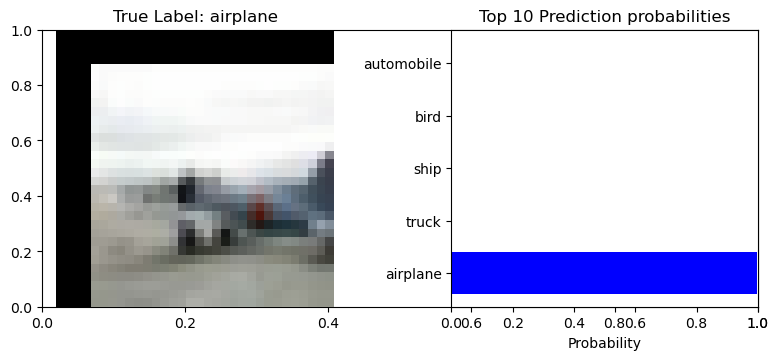

In [16]:
# Get a single image and its label from the test dataset
index = np.random.randint(len(test))  # Randomly select an index
image, label = test[index]

# Prepare the image for prediction
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    input_image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    outputs = model(input_image)                # Get model predictions
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)  # Apply softmax to get probabilities

plot_probabilities(
    image = image,
    label = label,
    probabilities = probabilities, 
    classes = test.classes,
    n = 5
)

In [17]:
evaluate(
    model = model,
    data_loader = val_loader,  # evaluate on validation data
    device = device,
    criterion = criterion,
    flatten = False
)

Evaluation Results:
Loss: 0.4789, Accuracy: 84.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       973
           1       0.98      0.78      0.87      1010
           2       0.89      0.74      0.81      1006
           3       0.74      0.73      0.73       967
           4       0.78      0.85      0.81       963
           5       0.89      0.74      0.81      1024
           6       0.90      0.88      0.89      1025
           7       0.82      0.91      0.86      1035
           8       0.84      0.97      0.90       998
           9       0.82      0.93      0.87       999

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



In [18]:
evaluate(
    model = model,
    data_loader = test_loader,  # evaluate on testing data
    device = device,
    criterion = criterion,
    flatten = False
)

Evaluation Results:
Loss: 0.4761, Accuracy: 84.29%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1000
           1       0.98      0.81      0.89      1000
           2       0.88      0.73      0.79      1000
           3       0.76      0.71      0.73      1000
           4       0.79      0.88      0.83      1000
           5       0.88      0.74      0.80      1000
           6       0.90      0.90      0.90      1000
           7       0.83      0.92      0.87      1000
           8       0.84      0.95      0.89      1000
           9       0.83      0.93      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000

